In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


Required packages

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import imutils
import zipfile
import os
import pickle
import uuid
import shutil

import cv2
from google.colab.patches import cv2_imshow

!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
#!wget https://github.com/tesseract-ocr/tessdata/blob/master/eng.traineddata

!pip install claptcha
from claptcha import Claptcha

from random import choices, random

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,409 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
# The network deals with captchas of lengths 4,5 and 6.
# For captchas of length 4 and 5, the last characters are predicted as space.
alphanum_without_space = '23456789QWERTYUPKJHGFDSAZXCVBNM'
alphanum = '23456789QWERTYUPKJHGFDSAZXCVBNM '

Dataset Generation

In [ ]:
def gen_dataset(orig_path, num_of_images, num_of_letters):
  path = os.path.join(orig_path,'train',str(num_of_letters))
  if os.path.exists(path):
    print('Data already created at path. Do you want to continue? (Y/N)')
    response = str(input())
    if (response.lower() == 'n'):
      print('Generation cancelled')
      return 0
    if (response.lower() == 'y'):
      shutil.rmtree(path)
      print('Deleting existing data')
  os.makedirs(path)
  print('Train folder created')
  for i in range(num_of_images):
    string = choices(alphanum_without_space,k=num_of_letters)
    captcha = ''.join(string)
    path_dest = os.path.join(path, '%s.png' % (captcha))
    c = Claptcha(captcha,'/content/drive/MyDrive/project/code/mitra.ttf')
    c.write(path_dest)
  print('Finished')
  return 1

In [ ]:
data_path = '/content/drive/MyDrive/project/code/data4'
num_of_images = 10000
if not os.path.exists(data_path):
  os.makedirs(data_path)
  print('Created')

gen_dataset(data_path, num_of_images, 6)

Created
Train folder created
Finished


1

In [ ]:
gen_dataset(data_path, num_of_images, 5)

Train folder created
Finished


1

In [ ]:
gen_dataset(data_path, num_of_images, 4)

Train folder created
Finished


1

Dataset Loading

In [ ]:
data_path = '/content/drive/MyDrive/project/code/data4'

In [ ]:
# Checking
dir = '/content/drive/MyDrive/project/code/data4/train/5'

onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
print(len(onlyfiles))

In [ ]:
def pre_process(img):
  new_size = (img.shape[1]*3,img.shape[0]*3)
  img = cv2.resize(img, new_size)
  img = cv2.bitwise_not(img)
  ret, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  kernel = np.ones((3,3), np.uint8)
  close = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
  inv = cv2.erode(close, kernel, iterations=1)
  final = cv2.bitwise_not(inv)
  return final

In [ ]:
def draw_boxes(final):
  custom_config = r'-l eng --oem 1 --psm 7 -c tessedit_char_whitelist="23456789QWERTYUPKJHGFDSAZXCVBNM"'
  text = pytesseract.image_to_boxes(final, config=custom_config)
  #print("Detected captcha is:", text)
  h, w= final.shape
  j = 0
  boxes = []
  for b in text.splitlines():
    b = b.split(' ')
    boxes.append((int(b[1]),int(b[2]),int(b[3]),int(b[4])))
    j = j+1
   # print(b)
    img = cv2.rectangle(final, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2).copy()
  boxes = list(set(boxes))
  #cv2_imshow(final)
  return boxes

In [ ]:
def arr_creator(z):
  arr = []
  for i in range(len(z[0])):
    arr_dum = []
    for j in range(6):
      arr_dum.append(z[j][i])
    #print(arr_dum)
    arr.append(arr_dum)
  return np.asarray(arr)

In [ ]:
def picklef(path,arr):
  if os.path.exists(path):
    os.remove(path)
  print('Deleted')
  with open(path,'wb') as f:
    pickle.dump(arr, f)
    print("Dumped")

In [ ]:
def pickledump(x_train, y_train, z_train,x_test,y_test,z_test,num_of_letters):
  ztest = arr_creator(z_test)
  ztrain = arr_creator(z_train)
  path_dest = os.path.join(data_path,"x_train_%d"%num_of_letters+".pkl")
  picklef(path_dest,x_train)
  path_dest = os.path.join(data_path,"y_train_%d"%num_of_letters+".pkl")
  picklef(path_dest,y_train)
  path_dest = os.path.join(data_path,"ztrain_%d"%num_of_letters+".pkl")
  picklef(path_dest,ztrain)
  path_dest = os.path.join(data_path,"x_test_%d"%num_of_letters+".pkl")
  picklef(path_dest,x_test)
  path_dest = os.path.join(data_path,"y_test_%d"%num_of_letters+".pkl")
  picklef(path_dest,y_test)
  path_dest = os.path.join(data_path,"ztest_%d"%num_of_letters+".pkl")
  picklef(path_dest,ztest)

In [ ]:
num_alphabet = len(alphanum)
print(num_alphabet)
print(alphanum.index(' '))
from random import random
def load_dataset(path, num_of_letters, test_split = 0.1):
  y_train = []
  y_test = []
  x_train = []
  x_test = []
  boxes_train = {}
  boxes_test = {}

  for i in range(6):
    boxes_train[i] = []
    boxes_test[i] = []
  counter = 0
  onlyfiles = next(os.walk(path))[2]
  for fl in onlyfiles:
      if '.png' in fl:
        print(counter) #use this to save every hundred or so
        label = np.zeros((6, num_alphabet))
        for i in range(num_of_letters):
          label[i, alphanum.index(fl[i].upper())] = 1
        for i in range(num_of_letters,6):
          label[i, alphanum.index(' ')] = 1
        #print(label.shape)
        img = cv2.imread(os.path.join(path,fl),0)
        final = pre_process(img)
        boxes = draw_boxes(final)
        img1 = cv2.resize(final, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
        final = np.reshape(img1, (img1.shape[0], img1.shape[1], 1))

        if random() < test_split:
          y_test.append(label)
          x_test.append(final)
          for i in range(6):
            if(i<len(boxes)):
              boxes_test[i].append(boxes[i])
            else:
              boxes_test[i].append((0,0,0,0))
        else:
          y_train.append(label)
          x_train.append(final)
          for i in range(6):
            if(i<len(boxes)):
              boxes_train[i].append(boxes[i])
            else:
              boxes_train[i].append((0,0,0,0))
        if(counter%10==0) or (counter==1):
          pickledump(np.array(x_train), np.array(y_train), boxes_train,np.array(x_test), np.array(y_test),boxes_test,num_of_letters)
          print("UPDATED")
        counter += 1
  return np.array(x_train), np.array(y_train), boxes_train,np.array(x_test), np.array(y_test),boxes_test

32
31


In [ ]:
x_train_6,y_train_6,z_train_6,x_test_6,y_test_6,z_test_6=load_dataset(os.path.join(data_path,"train",str(6)),6)

In [ ]:
x_train_5,y_train_5,z_train_5,x_test_5,y_test_5,z_test_5=load_dataset(os.path.join(data_path,"train",str(5)),5)

In [ ]:
x_train_4,y_train_4,z_train_4,x_test_4,y_test_4,z_test_4=load_dataset(os.path.join(data_path,"train",str(4)),4)

Run from here, replace the path appropriately.

In [ ]:
import os, pickle
data_path = "/content/drive/MyDrive/project/code/data4"
def pickleread(path):
  with open(path,'rb') as f:
    arr = pickle.load(f)
    print(arr.shape)
    return arr

In [ ]:
path_dest = os.path.join(data_path,"x_train_6.pkl")
x_train_6 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_train_6.pkl")
y_train_6 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztrain_6.pkl")
ztrain_6 = pickleread(path_dest)
path_dest = os.path.join(data_path,"x_test_6.pkl")
x_test_6 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_test_6.pkl")
y_test_6 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztest_6.pkl")
ztest_6 = pickleread(path_dest)

(8997, 25, 67, 1)
(8997, 6, 32)
(8997, 6, 4)
(994, 25, 67, 1)
(994, 6, 32)
(994, 6, 4)


In [ ]:
path_dest = os.path.join(data_path,"x_train_5.pkl")
x_train_5 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_train_5.pkl")
y_train_5 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztrain_5.pkl")
ztrain_5 = pickleread(path_dest)
path_dest = os.path.join(data_path,"x_test_5.pkl")
x_test_5 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_test_5.pkl")
y_test_5 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztest_5.pkl")
ztest_5 = pickleread(path_dest)

(9018, 25, 67, 1)
(9018, 6, 32)
(9018, 6, 4)
(973, 25, 67, 1)
(973, 6, 32)
(973, 6, 4)


In [ ]:
path_dest = os.path.join(data_path,"x_train_4.pkl")
x_train_4 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_train_4.pkl")
y_train_4 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztrain_4.pkl")
ztrain_4 = pickleread(path_dest)
path_dest = os.path.join(data_path,"x_test_4.pkl")
x_test_4 = pickleread(path_dest)
path_dest = os.path.join(data_path,"y_test_4.pkl")
y_test_4 = pickleread(path_dest)
path_dest = os.path.join(data_path,"ztest_4.pkl")
ztest_4 = pickleread(path_dest)

(8912, 25, 67, 1)
(8912, 6, 32)
(8912, 6, 4)
(1039, 25, 67, 1)
(1039, 6, 32)
(1039, 6, 4)


In [ ]:
path_2 = '/content/drive/MyDrive/project/code/data5'
path_dest = os.path.join(path_2,"x_train_6_data5.pkl")
x_train_6_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_train_6_data5.pkl")
y_train_6_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztrain_6_data5.pkl")
ztrain_6_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"x_test_6_data5.pkl")
x_test_6_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_test_6_data5.pkl")
y_test_6_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztest_6_data5.pkl")
ztest_6_data5 = pickleread(path_dest)

path_dest = os.path.join(path_2,"x_train_5_data5.pkl")
x_train_5_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_train_5_data5.pkl")
y_train_5_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztrain_5_data5.pkl")
ztrain_5_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"x_test_5_data5.pkl")
x_test_5_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_test_5_data5.pkl")
y_test_5_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztest_5_data5.pkl")
ztest_5_data5 = pickleread(path_dest)

path_dest = os.path.join(path_2,"x_train_4_data5.pkl")
x_train_4_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_train_4_data5.pkl")
y_train_4_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztrain_4_data5.pkl")
ztrain_4_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"x_test_4_data5.pkl")
x_test_4_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"y_test_4_data5.pkl")
y_test_4_data5 = pickleread(path_dest)
path_dest = os.path.join(path_2,"ztest_4_data5.pkl")
ztest_4_data5 = pickleread(path_dest)

(5349, 25, 67, 1)
(5349, 6, 32)
(5349, 6, 4)
(642, 25, 67, 1)
(642, 6, 32)
(642, 6, 4)
(5378, 25, 67, 1)
(5378, 6, 32)
(5378, 6, 4)
(613, 25, 67, 1)
(613, 6, 32)
(613, 6, 4)
(5379, 25, 67, 1)
(5379, 6, 32)
(5379, 6, 4)
(592, 25, 67, 1)
(592, 6, 32)
(592, 6, 4)


In [ ]:
x_train = np.concatenate((x_train_4, x_train_5,x_train_6,x_train_4_data5,x_train_5_data5,x_train_6_data5),axis=0)
y_train =np.concatenate((y_train_4,y_train_5,y_train_6,y_train_4_data5,y_train_5_data5,y_train_6_data5),axis=0)
x_test = np.concatenate((x_test_4,x_test_5,x_test_6,x_test_4_data5,x_test_5_data5,x_test_6_data5),axis=0)
y_test =  np.concatenate((y_test_4,y_test_5,y_test_6,y_test_4_data5,y_test_5_data5,y_test_6_data5),axis=0)
ztrain = np.concatenate((ztrain_4, ztrain_5,ztrain_6,ztrain_4_data5,ztrain_5_data5,ztrain_6_data5),axis=0)
ztest = np.concatenate((ztest_4, ztest_5,ztest_6,ztest_4_data5,ztest_5_data5,ztest_6_data5),axis=0)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#ztrain = ztrain/600
#ztest = ztest/600

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(43033, 25, 67, 1)
(4853, 25, 67, 1)
(43033, 6, 32)
(4853, 6, 32)


In [ ]:
def normalizer(z):
  mean = np.mean(z,axis = 0)
  var = np.var(z,axis=0)
  return mean,var

In [ ]:
###
mean,var = normalizer(ztest)
ztest = np.divide(ztest-mean,var)
mean,var = normalizer(ztrain)
ztrain = np.divide(ztrain-mean,var)

In [ ]:
s_train = []
s_test = []
for i in range(6):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [ ]:
save_dir = os.path.join("/content/drive/MyDrive/project", 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [ ]:
num_alphabet = len(alphanum)
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

input_A = Input((25, 67, 1))
input_B = Input((6,4,1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_A)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

#x = Dropout(0.3)(x)
x = Flatten()(x)
x_out = Dense(512, activation='relu')(x)
#x = Dropout(0.3)(x)
x = Model(inputs = input_A,outputs = x_out)

y = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_B)
y = MaxPooling2D(pool_size=(2, 2))(y)

#y = Dropout(0.3)(y)
y = Flatten()(y)
y_out = Dense(512, activation='relu')(y)
#y_out = Dropout(0.3)(y)
y = Model(inputs = input_B,outputs = y_out)

combined = Concatenate()([x.output, y.output])

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(combined) for i in range(6)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model2 = Model(inputs=[x.input,y.input], outputs=out)

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 25, 67, 32)   832         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 12, 33, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 12, 33, 48)   38448       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [ ]:
history = model2.fit(x = [x_train,ztrain], y = s_train,
                    validation_data=([x_test,ztest], s_test),
                    batch_size=128,
                    epochs=100,
                    verbose=1
                   )

Epoch 1/100


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py", line 444, in converted_call
    result = converted_f(*effective_args, **kwargs)
  File "/tmp/tmpef7mrss0.py", line 162, in tf___run_internal_graph
    ag__.for_stmt(ag__.ld(depth_keys), None, loop_body_4, get_state_9, set_state_9, (), {'iterate_names': 'depth'})
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 443, in for_stmt
    _py_for_stmt(iter_, extra_test, body, None, None)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 472, in _py_for_stmt
    body(target)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 458, in protected_body
    original_body(protected_iter)
  File "/tmp/tmpef7mrss0.py", line 154, in loop_body_4
    ag__.for_stmt(ag__.ld(nodes), None, loop_body_3, get_state_8, se

TypeError: ignored

In [ ]:
scores = model2.evaluate([x_train,ztrain], s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Train accuracy: %.2f' % (acc * 100.))

1345/1345 [==============================] - 8s 6ms/step - loss: 0.0026 - digit0_loss: 3.0454e-04 - digit1_loss: 3.7668e-04 - digit2_loss: 5.2756e-04 - digit3_loss: 7.5819e-04 - digit4_loss: 4.1070e-04 - digit5_loss: 2.3211e-04 - digit0_accuracy: 0.9999 - digit1_accuracy: 0.9996 - digit2_accuracy: 0.9999 - digit3_accuracy: 0.9998 - digit4_accuracy: 0.9998 - digit5_accuracy: 1.0000
Train loss:     0.000831
Train accuracy: 99.88


In [ ]:
scores = model2.evaluate([x_test,ztest], s_test, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Train accuracy: %.2f' % (acc * 100.))

152/152 [==============================] - 1s 7ms/step - loss: 0.0589 - digit0_loss: 0.0066 - digit1_loss: 0.0094 - digit2_loss: 0.0109 - digit3_loss: 0.0128 - digit4_loss: 0.0116 - digit5_loss: 0.0075 - digit0_accuracy: 0.9773 - digit1_accuracy: 0.9689 - digit2_accuracy: 0.9637 - digit3_accuracy: 0.9573 - digit4_accuracy: 0.9666 - digit5_accuracy: 0.9780
Train loss:     0.018374
Train accuracy: 82.59


In [ ]:
# Without normalizing data, it gave very poor results.

Model 3

In [ ]:
num_alphabet = len(alphanum)
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

input_A = Input((25, 67, 1))
input_B = Input((6,4,1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_A)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x_out = Dense(512, activation='relu')(x)
#x = Dropout(0.3)(x)
x = Model(inputs = input_A,outputs = x_out)

y = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_B)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(y)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(y)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Dropout(0.3)(y)
y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y_out = Dropout(0.3)(y)
y = Model(inputs = input_B,outputs = y_out)

combined = Concatenate()([x.output, y.output])

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(combined) for i in range(6)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model3 = Model(inputs=[x.input,y.input], outputs=out)

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 4, 1)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 4, 32)     832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 67, 32)   832         input_1[0][0]                    
____________________________________________________________________________________________

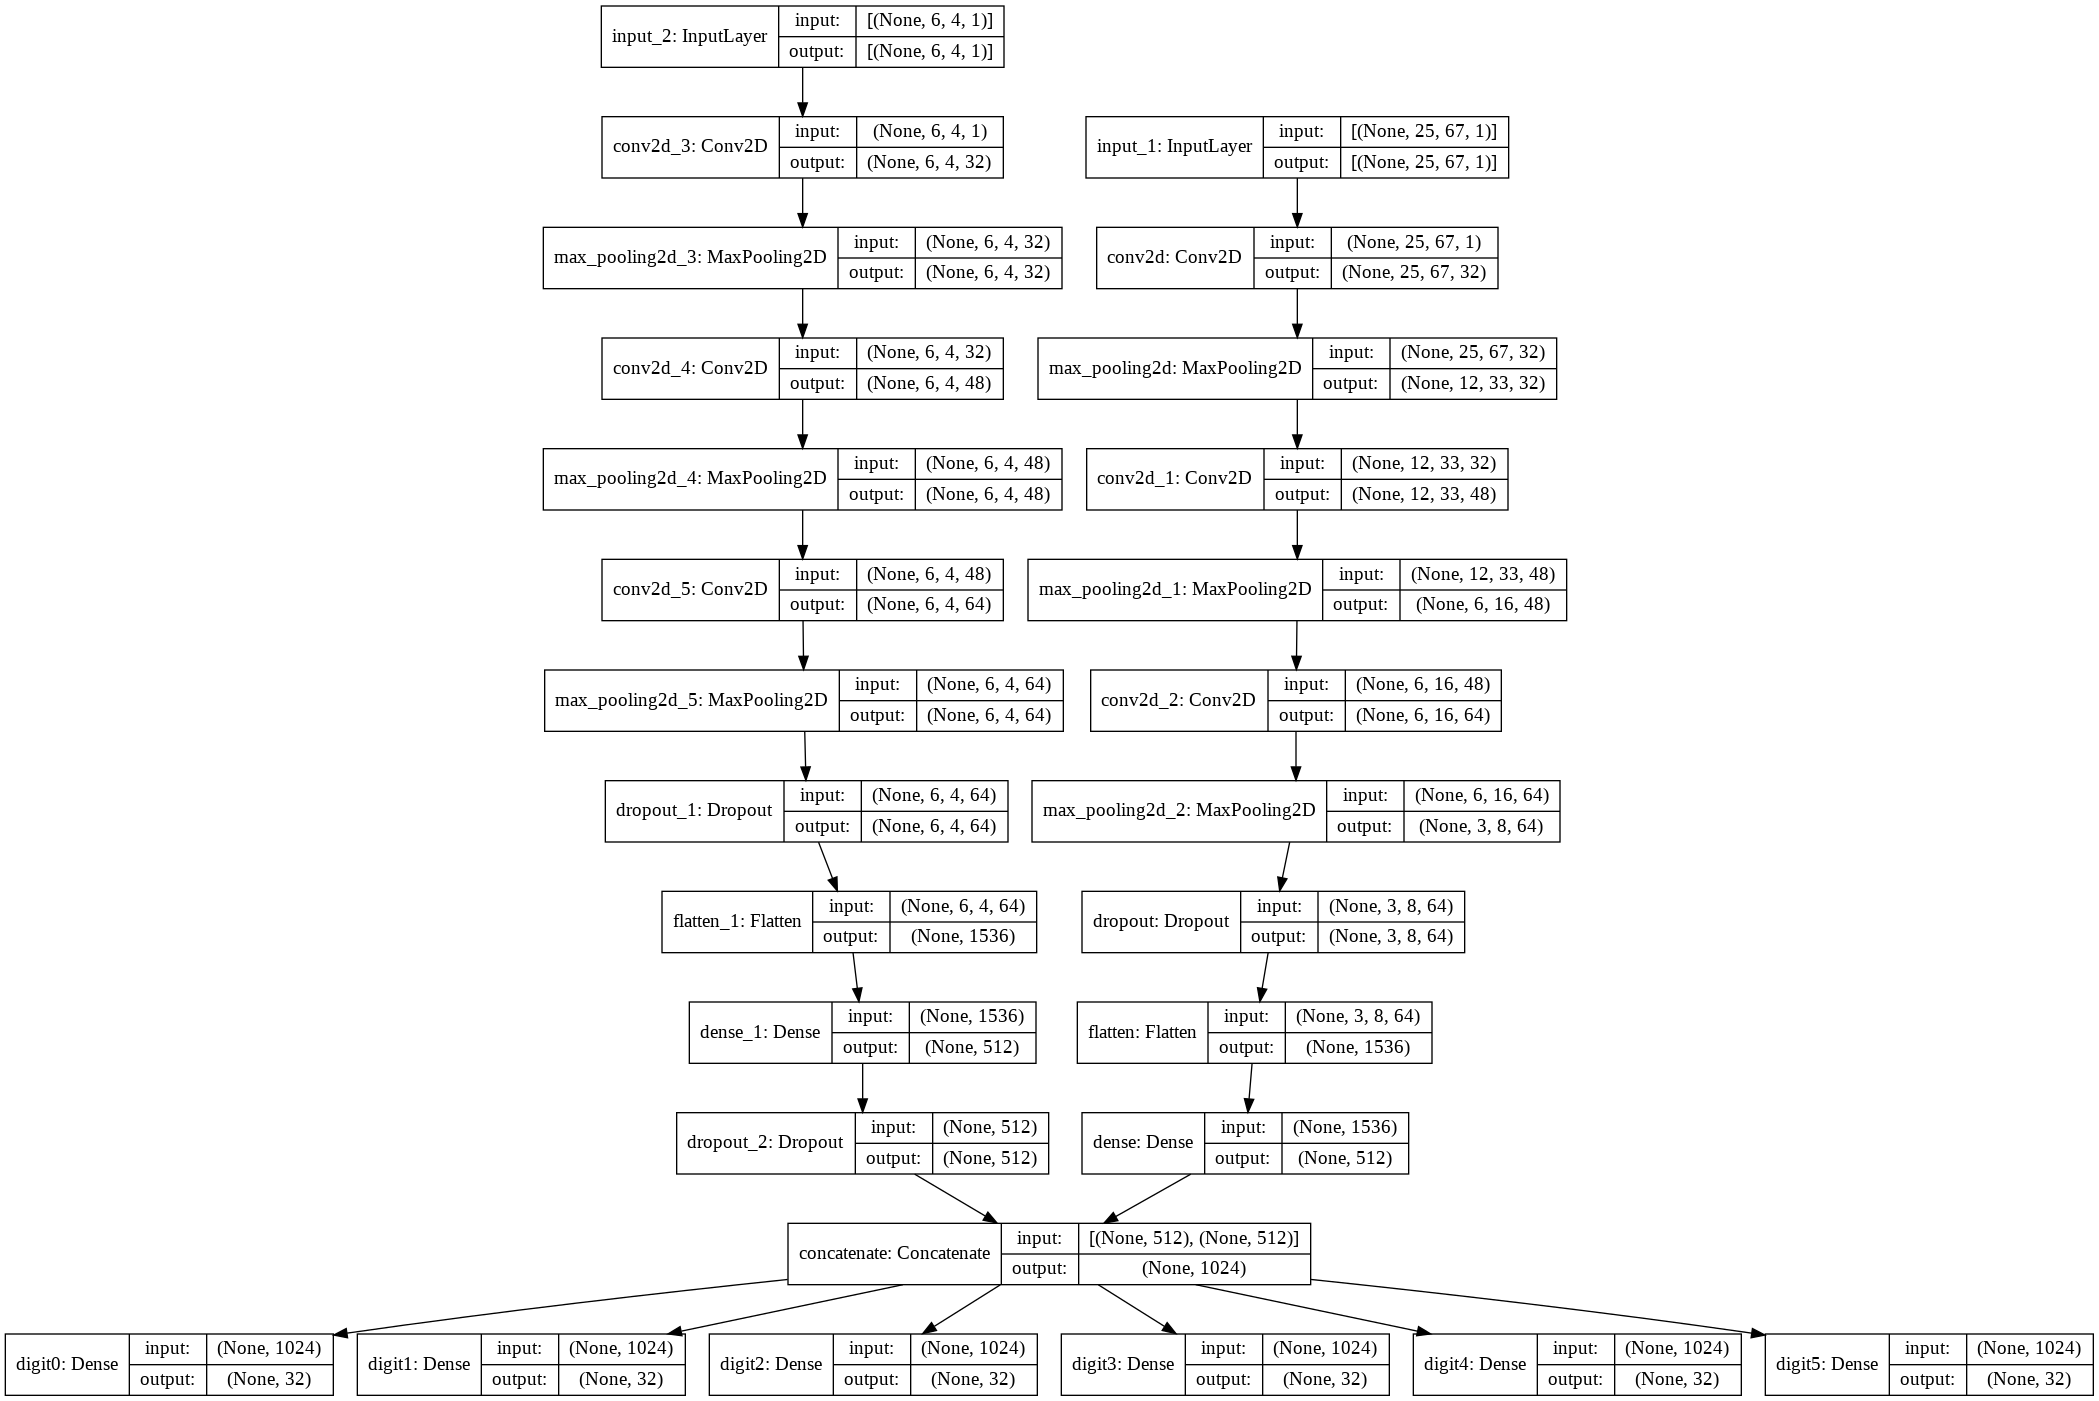

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model3.fit(x = [x_train,ztrain], y = s_train,
                    validation_data=([x_test,ztest], s_test),
                    batch_size=128,
                    epochs=140,
                    verbose=1
                   )
# take 256 and 100/128 and 200

Epoch 1/140
337/337 [==============================] - 54s 23ms/step - loss: 0.9713 - digit0_loss: 0.1761 - digit1_loss: 0.1758 - digit2_loss: 0.1753 - digit3_loss: 0.1744 - digit4_loss: 0.1563 - digit5_loss: 0.1134 - digit0_accuracy: 0.0331 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0328 - digit3_accuracy: 0.0306 - digit4_accuracy: 0.3041 - digit5_accuracy: 0.6206 - val_loss: 0.7458 - val_digit0_loss: 0.1388 - val_digit1_loss: 0.1391 - val_digit2_loss: 0.1391 - val_digit3_loss: 0.1389 - val_digit4_loss: 0.1163 - val_digit5_loss: 0.0735 - val_digit0_accuracy: 0.0367 - val_digit1_accuracy: 0.0361 - val_digit2_accuracy: 0.0305 - val_digit3_accuracy: 0.0342 - val_digit4_accuracy: 0.3363 - val_digit5_accuracy: 0.6629
Epoch 2/140
337/337 [==============================] - 6s 18ms/step - loss: 0.7334 - digit0_loss: 0.1377 - digit1_loss: 0.1388 - digit2_loss: 0.1388 - digit3_loss: 0.1389 - digit4_loss: 0.1115 - digit5_loss: 0.0678 - digit0_accuracy: 0.0471 - digit1_accuracy: 0.0416 - digi

In [ ]:
scores = model.evaluate([x_test,ztest], s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Test accuracy: %.2f' % (acc * 100.))

152/152 [==============================] - 2s 12ms/step - loss: 0.0597 - digit0_loss: 0.0070 - digit1_loss: 0.0093 - digit2_loss: 0.0109 - digit3_loss: 0.0128 - digit4_loss: 0.0121 - digit5_loss: 0.0076 - digit0_accuracy: 0.9827 - digit1_accuracy: 0.9761 - digit2_accuracy: 0.9681 - digit3_accuracy: 0.9646 - digit4_accuracy: 0.9679 - digit5_accuracy: 0.9786
Test loss:     0.018639
Test accuracy: 84.83


In [ ]:
for i in range(6):
  print("For digit %d"%(i+1))
  print("Test accuracy:",scores[7+i]*100)

For digit 1
Test accuracy: 98.26911091804504
For digit 2
Test accuracy: 97.60972857475281
For digit 3
Test accuracy: 96.80609703063965
For digit 4
Test accuracy: 96.45580053329468
For digit 5
Test accuracy: 96.7854917049408
For digit 6
Test accuracy: 97.85699844360352


In [ ]:
scores = model.evaluate([x_train,ztrain], s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Train accuracy: %.2f' % (acc * 100.))

1345/1345 [==============================] - 16s 12ms/step - loss: 0.0012 - digit0_loss: 1.5091e-04 - digit1_loss: 1.7415e-04 - digit2_loss: 1.9789e-04 - digit3_loss: 3.2705e-04 - digit4_loss: 1.7305e-04 - digit5_loss: 1.7721e-04 - digit0_accuracy: 0.9998 - digit1_accuracy: 0.9999 - digit2_accuracy: 0.9999 - digit3_accuracy: 0.9998 - digit4_accuracy: 1.0000 - digit5_accuracy: 0.9999
Train loss:     0.000371
Train accuracy: 99.93


In [ ]:
for i in range(6):
  print("For digit %d"%(i+1))
  print("Train accuracy:",scores[7+i]*100)

For digit 1
Train accuracy: 99.97908473014832
For digit 2
Train accuracy: 99.99070763587952
For digit 3
Train accuracy: 99.99070763587952
For digit 4
Train accuracy: 99.9837338924408
For digit 5
Train accuracy: 99.99767541885376
For digit 6
Train accuracy: 99.99070763587952


In [ ]:
def predictor(string):
  captcha = ''.join(string)
  test_img = Claptcha(captcha,'/content/drive/MyDrive/project/code/mitra.ttf')
  test_img.write("test_img.png")

  img = cv2.imread('test_img.png',0)
  final = pre_process(img)
  boxes = draw_boxes(final)
  img1 = cv2.resize(final, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
  final = np.reshape(img1, (img1.shape[0], img1.shape[1], 1))
  boxes_dict = {}
  for i in range(6):
    boxes_dict[i] = []
  for i in range(6):
    if(i<len(boxes)):
      boxes_dict[i].append(boxes[i])
    else:
      boxes_dict[i].append((0,0,0,0))
  #print(boxes_dict)
  arr_dum = []
  for j in range(6):
    arr_dum.append(boxes_dict[j])
  z = np.array(arr_dum)
  final = final.reshape(1,25,67,1)
  z = z.reshape(1,6,4,1)
  z = np.divide(z,np.linalg.norm(z))
  y = model.predict([final,z])

  output = []
  for i in range(6):
    index = np.where(y[i][0]==1)
    output.append(alphanum[index[0][0]])
  #print(output)
  o = ''
  o = o.join(output).strip()
  print(o)

  cv2_imshow(img)

AFRR


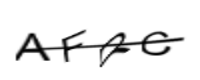

In [ ]:
predictor('AFRC')

In [ ]:
save_path = '/content/drive/MyDrive/project/saved_models'
model3.save(os.path.join(save_path,'model3_16000_2.h5'))

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/project/saved_models/model3_16000_2.h5')

Model 4

In [ ]:
# with 10000 images
x_train = np.concatenate((x_train_4, x_train_5,x_train_6),axis=0)
y_train =np.concatenate((y_train_4,y_train_5,y_train_6),axis=0)
x_test = np.concatenate((x_test_4,x_test_5,x_test_6,),axis=0)
y_test =  np.concatenate((y_test_4,y_test_5,y_test_6),axis=0)
ztrain = np.concatenate((ztrain_4, ztrain_5,ztrain_6),axis=0)
ztest = np.concatenate((ztest_4, ztest_5,ztest_6),axis=0)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#ztrain = ztrain/600
#ztest = ztest/600

In [ ]:
print(x_train.shape)

(26927, 25, 67, 1)


In [ ]:
def normalizer(z):
  mean = np.mean(z,axis = 0)
  var = np.var(z,axis=0)
  return mean,var

In [ ]:
mean,var = normalizer(ztest)
ztest = np.divide(ztest-mean,var)
mean,var = normalizer(ztrain)
ztrain = np.divide(ztrain-mean,var)

In [ ]:
s_train = []
s_test = []
for i in range(6):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [ ]:
num_alphabet = len(alphanum)
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

input_A = Input((25, 67, 1))
input_B = Input((6,4,1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_A)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x_out = Dense(512, activation='relu')(x)
#x = Dropout(0.3)(x)
x = Model(inputs = input_A,outputs = x_out)

y = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_B)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(y)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(y)
y = MaxPooling2D(pool_size=(1, 1))(y)

y = Dropout(0.3)(y)
y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y_out = Dropout(0.3)(y)
y = Model(inputs = input_B,outputs = y_out)

combined = Concatenate()([x.output, y.output])

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(combined) for i in range(6)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model4 = Model(inputs=[x.input,y.input], outputs=out)

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 8, min_delta = 0.001)

In [ ]:
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 4, 1)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 4, 32)     832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 67, 32)   832         input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model4.fit(x = [x_train,ztrain], y = s_train,
                    validation_data=([x_test,ztest], s_test),
                    batch_size=128,
                    callbacks = [es],
                    epochs=100,
                    verbose=1
                   )
# take 256 and 100/128 and 200

Epoch 1/100
211/211 [==============================] - 4s 19ms/step - loss: 0.4395 - digit0_loss: 0.0615 - digit1_loss: 0.0835 - digit2_loss: 0.0917 - digit3_loss: 0.0987 - digit4_loss: 0.0703 - digit5_loss: 0.0338 - digit0_accuracy: 0.6795 - digit1_accuracy: 0.5063 - digit2_accuracy: 0.4309 - digit3_accuracy: 0.3652 - digit4_accuracy: 0.5473 - digit5_accuracy: 0.7872 - val_loss: 0.3702 - val_digit0_loss: 0.0463 - val_digit1_loss: 0.0698 - val_digit2_loss: 0.0779 - val_digit3_loss: 0.0850 - val_digit4_loss: 0.0622 - val_digit5_loss: 0.0291 - val_digit0_accuracy: 0.7911 - val_digit1_accuracy: 0.6450 - val_digit2_accuracy: 0.5655 - val_digit3_accuracy: 0.4867 - val_digit4_accuracy: 0.6068 - val_digit5_accuracy: 0.8327
Epoch 2/100
211/211 [==============================] - 4s 19ms/step - loss: 0.3586 - digit0_loss: 0.0463 - digit1_loss: 0.0670 - digit2_loss: 0.0755 - digit3_loss: 0.0821 - digit4_loss: 0.0595 - digit5_loss: 0.0282 - digit0_accuracy: 0.7766 - digit1_accuracy: 0.6421 - digit

In [ ]:
from keras.models import load_model
model_4 = load_model('/content/drive/MyDrive/project/saved_models/model4_10000.h5')

In [ ]:
scores = model4.evaluate([x_test,ztest], s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Test accuracy: %.2f' % (acc * 100.))

94/94 [==============================] - 1s 7ms/step - loss: 0.0819 - digit0_loss: 0.0098 - digit1_loss: 0.0125 - digit2_loss: 0.0165 - digit3_loss: 0.0180 - digit4_loss: 0.0166 - digit5_loss: 0.0085 - digit0_accuracy: 0.9684 - digit1_accuracy: 0.9541 - digit2_accuracy: 0.9418 - digit3_accuracy: 0.9371 - digit4_accuracy: 0.9351 - digit5_accuracy: 0.9657
Test loss:     0.025879
Test accuracy: 73.64


In [ ]:
scores = model_4.evaluate([x_test,ztest], s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Test accuracy: %.2f' % (acc * 100.))

NameError: ignored

In [ ]:
for i in range(6):
  print("For digit %d"%(i+1))
  print("Test accuracy:",scores[7+i]*100)

For digit 1
Test accuracy: 96.8396544456482
For digit 2
Test accuracy: 95.40917873382568
For digit 3
Test accuracy: 94.17831301689148
For digit 4
Test accuracy: 93.71257424354553
For digit 5
Test accuracy: 93.51297616958618
For digit 6
Test accuracy: 96.57351970672607


In [ ]:
scores = model4.evaluate([x_train,ztrain], s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Train accuracy: %.2f' % (acc * 100.))

842/842 [==============================] - 5s 6ms/step - loss: 0.0089 - digit0_loss: 7.8702e-04 - digit1_loss: 0.0013 - digit2_loss: 0.0017 - digit3_loss: 0.0024 - digit4_loss: 0.0019 - digit5_loss: 8.8574e-04 - digit0_accuracy: 0.9996 - digit1_accuracy: 0.9994 - digit2_accuracy: 0.9991 - digit3_accuracy: 0.9989 - digit4_accuracy: 0.9983 - digit5_accuracy: 0.9994
Train loss:     0.002820
Train accuracy: 99.48


In [ ]:
scores = model_4.evaluate([x_train,ztrain], s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:6]))
acc = 1.
for i in range(6):
    acc *= scores[7+i]
print('Train accuracy: %.2f' % (acc * 100.))

842/842 [==============================] - 5s 6ms/step - loss: 0.0018 - digit0_loss: 2.8009e-04 - digit1_loss: 2.1076e-04 - digit2_loss: 3.5887e-04 - digit3_loss: 3.9840e-04 - digit4_loss: 4.7327e-04 - digit5_loss: 1.0988e-04 - digit0_accuracy: 1.0000 - digit1_accuracy: 1.0000 - digit2_accuracy: 0.9999 - digit3_accuracy: 1.0000 - digit4_accuracy: 0.9998 - digit5_accuracy: 1.0000
Train loss:     0.000592
Train accuracy: 99.97


In [ ]:
for i in range(6):
  print("For digit %d"%(i+1))
  print("Train accuracy:",scores[7+i]*100)

For digit 1
Train accuracy: 99.9962866306305
For digit 2
Train accuracy: 100.0
For digit 3
Train accuracy: 99.99257326126099
For digit 4
Train accuracy: 100.0
For digit 5
Train accuracy: 99.97771978378296
For digit 6
Train accuracy: 100.0


In [ ]:
def predictor(string):
  captcha = ''.join(string)
  test_img = Claptcha(captcha,'/content/drive/MyDrive/project/code/mitra.ttf')
  test_img.write("test_img.png")

  img = cv2.imread('test_img.png',0)
  final = pre_process(img)
  boxes = draw_boxes(final)
  img1 = cv2.resize(final, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
  final = np.reshape(img1, (img1.shape[0], img1.shape[1], 1))
  boxes_dict = {}
  for i in range(6):
    boxes_dict[i] = []
  for i in range(6):
    if(i<len(boxes)):
      boxes_dict[i].append(boxes[i])
    else:
      boxes_dict[i].append((0,0,0,0))
  #print(boxes_dict)
  arr_dum = []
  for j in range(6):
    arr_dum.append(boxes_dict[j])
  z = np.array(arr_dum)
  final = final.reshape(1,25,67,1)
  z = z.reshape(1,6,4,1)
  z = np.divide(z,np.linalg.norm(z))
  y = model4.predict([final,z])

  output = []
  for i in range(6):
    index = np.where(y[i][0]==1)
    output.append(alphanum[index[0][0]])
  #print(output)
  o = ''
  o = o.join(output).strip()
  print(o)

  cv2_imshow(img)

AFTS


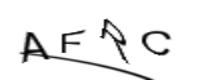

In [ ]:
predictor('AFRC')

In [ ]:
save_path = '/content/drive/MyDrive/project/saved_models'
model4.save(os.path.join(save_path,'model4_10000.h5'))